In [18]:
pip install plotly_express==0.4.0

In [19]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)




# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

ImportError: ignored

In [20]:
pip install chart-studio

In [21]:
from chart_studio import plotly

In [22]:
from chart-studio import pyplot as ply

SyntaxError: ignored

In [ ]:
import plotly
plotly.__version__


'5.15.0'

In [ ]:
!pip install plotly==5.15.0
from chart_studio import plotly

ModuleNotFoundError: ignored

In [23]:
import plotly.offline as pyoff
import plotly.graph_objs as go

## Context

We have a rich dataset containing large number of player attributes. To help managers better understand player characteristics, we can generate archetype of player profiles. We can achieve this by applying unsupervised learning techniques. In this kernel, I would like to go through different ways to do the clustering and also communicate the results

A couple different techniques & libraries being used in this kernel:
* **Comparing PCA & TSNE** for dimensionality reduction. In particular, we use PCA for clustering, and TSNE primarily for visualization. We also compare 2D viz from PCA and TSNE
* **Pandas Profiling** library for EDA
* **Combination of Plotly, Plotly Express, and Seaborn** Plotly / Plotly Express gives interactivity, as we can hover on the chart. However, Plotly / Express don't work well for scatter plot because it stores each data point, thus the size of the notebook gets too large, so we revert to regular Seaborn
* **Cluster Explainer** Lastly we use selective-variable charts to profile unique characteristic of clusters

## Data Preparation & Clean Up

In [24]:
df=pd.read_csv('/content/Player_Attributes.csv')

In [25]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

#### We select only skills attributes for clustering
In total there are 34 columns. There are 5 skills that are specific to Goal Keepers, but the value is still nonzero for non-GK players. In this iteration, we will keep the Goal Keepers skills to observe how it will behave in the clustering

In [39]:
#skill_cols = ['Crossing','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',  'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',       'GKKicking', 'GKPositioning', 'GKReflexes']
skill_cols=['crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
dfskills = df[skill_cols]
len(dfskills.columns)

33

# Pandas Profiling for EDA and data cleaning
Pandas Profiling is a very convenient library to do quick overview EDA. It is useful for us to understand the landscape of each variables in the dataset. In addition, Pandas Profiling provides diagnostics and recommendation on missing values and correlated variables.

In the Pandas Profiling output below, we will observe that some variables are correlated and suggested to be removed. Nonetheless, we will keep it in this iteration. From the Profiling, there are only 0.2% of players having missing value, so we will just drop them out of the dataset.

Go check out more information about Pandas Profiling in here: https://github.com/pandas-profiling/pandas-profiling

*Note: I had to comment out Pandas Profiling when committing the Kernel, because it seems that the html file gets too large for the commit 1MB limit. I got this message when running it: "An error occurred while commiting kernel: The kernel source must be less than 1 megabyte in size"*

In [41]:
import sys
!{sys.executable} -m pip install pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27082 sha256=3fd0c4f43c229a9ccf617466aa387f1d297e055ad5588743122bb29b328af2d9
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting unin

In [44]:
pip install typing-extensions --upgrade

In [45]:
import pandas_profiling
# pandas_profiling.ProfileReport(dfskills)

ImportError: ignored

In [46]:
dfskills.dropna(inplace=True)

<ipython-input-46-74f19cb84b83>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## We also manually create correlation heatmap manually using Plotly
Plotly enables you to hover and examine each variable

In [55]:
corr = dfskills.corr()
trace = go.Heatmap(z=corr,x=corr.index,y=corr.columns)
data = [trace]
layout = dict(title="Correlation Plot of Player Skills")
fig = dict(data=data, layout=layout)
plt.show(fig)
#iplot(fig)

# PCA to reduce dimensionality
In this step we are using PCA to reduce the dimensionality of original attribute space. We use PCA Explained Variance plot below to help determine the right level of components. We chose 5 components PCA as it can achieve 89% explained variance with just few components. As you can see later in the notebook, the result of kmeans clusterint from using 5 components looks very similar with clustering based on the full variables, except for a small number of observations that are sprinkled away from the big clusters

In [50]:
from sklearn.decomposition import PCA
pca = PCA().fit(dfskills)

In [56]:
pcaratio = pca.explained_variance_ratio_
trace = go.Scatter(x=np.arange(len(pcaratio)),y=np.cumsum(pcaratio))
data = [trace]
layout = dict(title="Player Skills Dataset - PCA Explained Variance || 89% achieved at 5 components")
fig = dict(data=data, layout=layout)

#iplot(fig)

In [57]:
pca = PCA(n_components=5)
skillsPCA = pca.fit_transform(dfskills)

# Clustering 1: Create clusters based on PCA (5D) transformed
After we have the 5-D, we create clusters using just those 5 components. Here we pick an arbitrary number of 6 clusters for illustration, but you should review the elbow curve to pick more optimal clustering.

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
skillsPCA_labels = kmeans.fit_predict(skillsPCA)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
dfskillsPCA = pd.DataFrame(skillsPCA)
dfskillsPCA['cluster'] = skillsPCA_labels

# Clustering 1A: Visualize clustering-1 using TSNE (5D > 2D)
The TSNE here is created from the 5D PCA components. In contrast, later on we will create the TSNE that is based on the original 34 variables. We will see later that the visualized 2D scatter doesn't look to different. However, the computational time required for TSNE from original vector space is much longer

In [ ]:
from sklearn.manifold import TSNE
X = dfskillsPCA.iloc[:,:-1]
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = skillsPCA_labels
dftsne.columns = ['x1','x2','cluster']

# Clustering 1B: Visualize clustering-1 using PCA 2D for comparison
What if we use PCA instead of TSNE? PCA has a much faster compute, but will we lose a lot in terms of visualization and insight?
In our case, it's not too much different. But in other cases, you could find that there are a lot of manifolds of the data that could be seen better with TSNE, which got "squeezed" when just using PCA

In [ ]:
pca2 = PCA(n_components=2)
skillsPCA2 = pca2.fit_transform(dfskills)
dfskillsPCA2 = pd.DataFrame(skillsPCA2)
dfskillsPCA2['cluster'] = skillsPCA_labels
dfskillsPCA2.columns = ['x1','x2','cluster']


# Comparing Clustering 1A and 1B

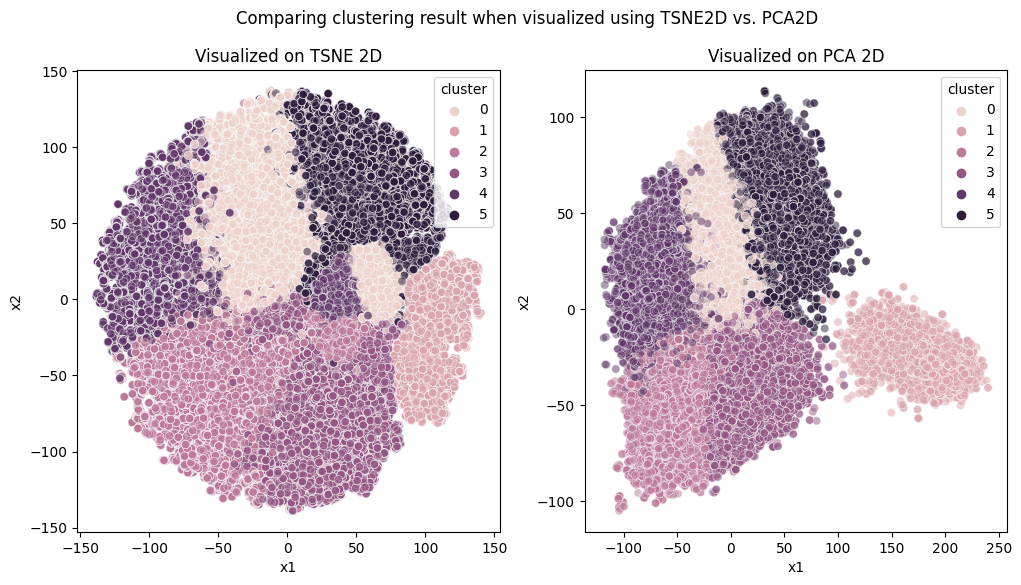

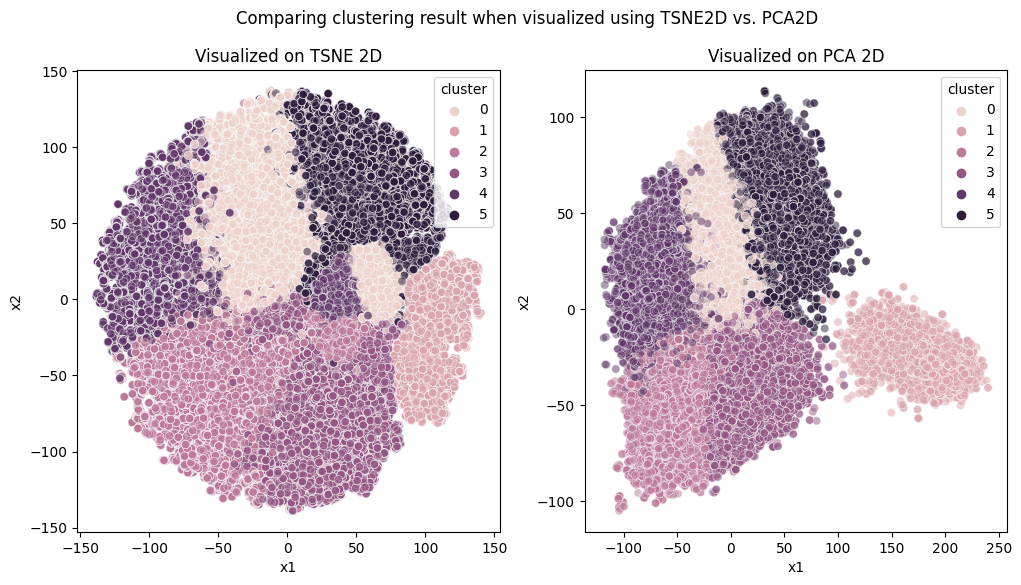

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfskillsPCA2,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D')
display(fig)

# Clustering 2: Create clusters based on full original dimensions (34 vars)

In [ ]:
kmeans = KMeans(n_clusters=6)
clustering_ori = kmeans.fit_predict(dfskills)

# Clustering 2A: Visualize clustering-2 using TSNE (5D > 2D)**

In [ ]:
dftsne2D = dftsne
dftsne2D['cluster'] = clustering_ori

# Clustering 2B: Visualize clustering-2 using TSNE (34D > 2D)**

In [ ]:
X = dfskills
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsneFull = pd.DataFrame(Xtsne)

In [ ]:
dftsneFull['cluster'] = clustering_ori
dftsneFull.columns = ['x1','x2','cluster']

# Comparing Clustering 2A and Clustering 2B

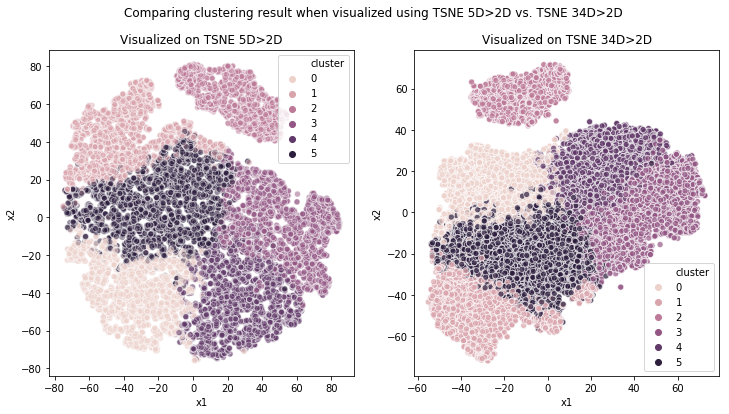

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=dftsne2D,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE 5D>2D')
sns.scatterplot(data=dftsneFull,x='x1',y='x2',hue='cluster',legend="full",alpha=0.7,ax=ax[1])
ax[1].set_title('Visualized on TSNE 34D>2D')
fig.suptitle('Comparing clustering result when visualized using TSNE 5D>2D vs. TSNE 34D>2D')
display(fig)

# Profiling each of the cluster

For each cluster, we want to show the average stats of the cluster, and highlight the distinguishing characteristics. We don't want to show the entire set of attributes for each cluster, but we just want to highlight metrics that are "unique" (i.e. significantly different from global mean)

In [ ]:
dfskills['cluster'] = clustering_ori

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
# Some functions to plot just the variables that has significant deviation from global mean
def outside_limit(df, label_col, label, sensitivity):
  feature_list = dfskills.columns[:-1]

  plot_list = []
  mean_overall_list = []
  mean_cluster_list = []

  for i,varname in enumerate(feature_list):

    #     get overall mean for a variable, set lower and upper limit
    mean_overall = df[varname].mean()
    lower_limit = mean_overall - (mean_overall*sensitivity)
    upper_limit = mean_overall + (mean_overall*sensitivity)

    #     get cluster mean for a variable
    cluster_filter = df[label_col]==label
    pd_cluster = df[cluster_filter]
    mean_cluster = pd_cluster[varname].mean()

    #     create filter to display graph with 0.5 deviation from the mean
    if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
      plot_list.append(varname)
      mean_overall_std = mean_overall/mean_overall
      mean_cluster_std = mean_cluster/mean_overall
      mean_overall_list.append(mean_overall_std)
      mean_cluster_list.append(mean_cluster_std)

  mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
  mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)

  return mean_df

def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):

  mean_df = outside_limit(df, label_col, label, sensitivity)
  mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)

  if len(mean_df.index) != 0:
    sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

    for i,p in enumerate(ax.patches):
      ax.annotate("{:.02f}".format((p.get_width())),
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0,
                  xytext=(0, 0),
                  textcoords='offset pixels')

  ax.set_title('Unique Characteristics of Cluster ' + str(label))
  ax.set_xlabel('Standardized Mean')
  ax.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
  n_plot = n_clusters
  fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
  ax= ax.ravel()

  label = np.arange(n_clusters)
  for i in label:
    plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
    ax[i].xaxis.set_tick_params(labelbottom=True)

  plt.tight_layout()
  display(fig)

### Now we plot unique characteristics of each cluster

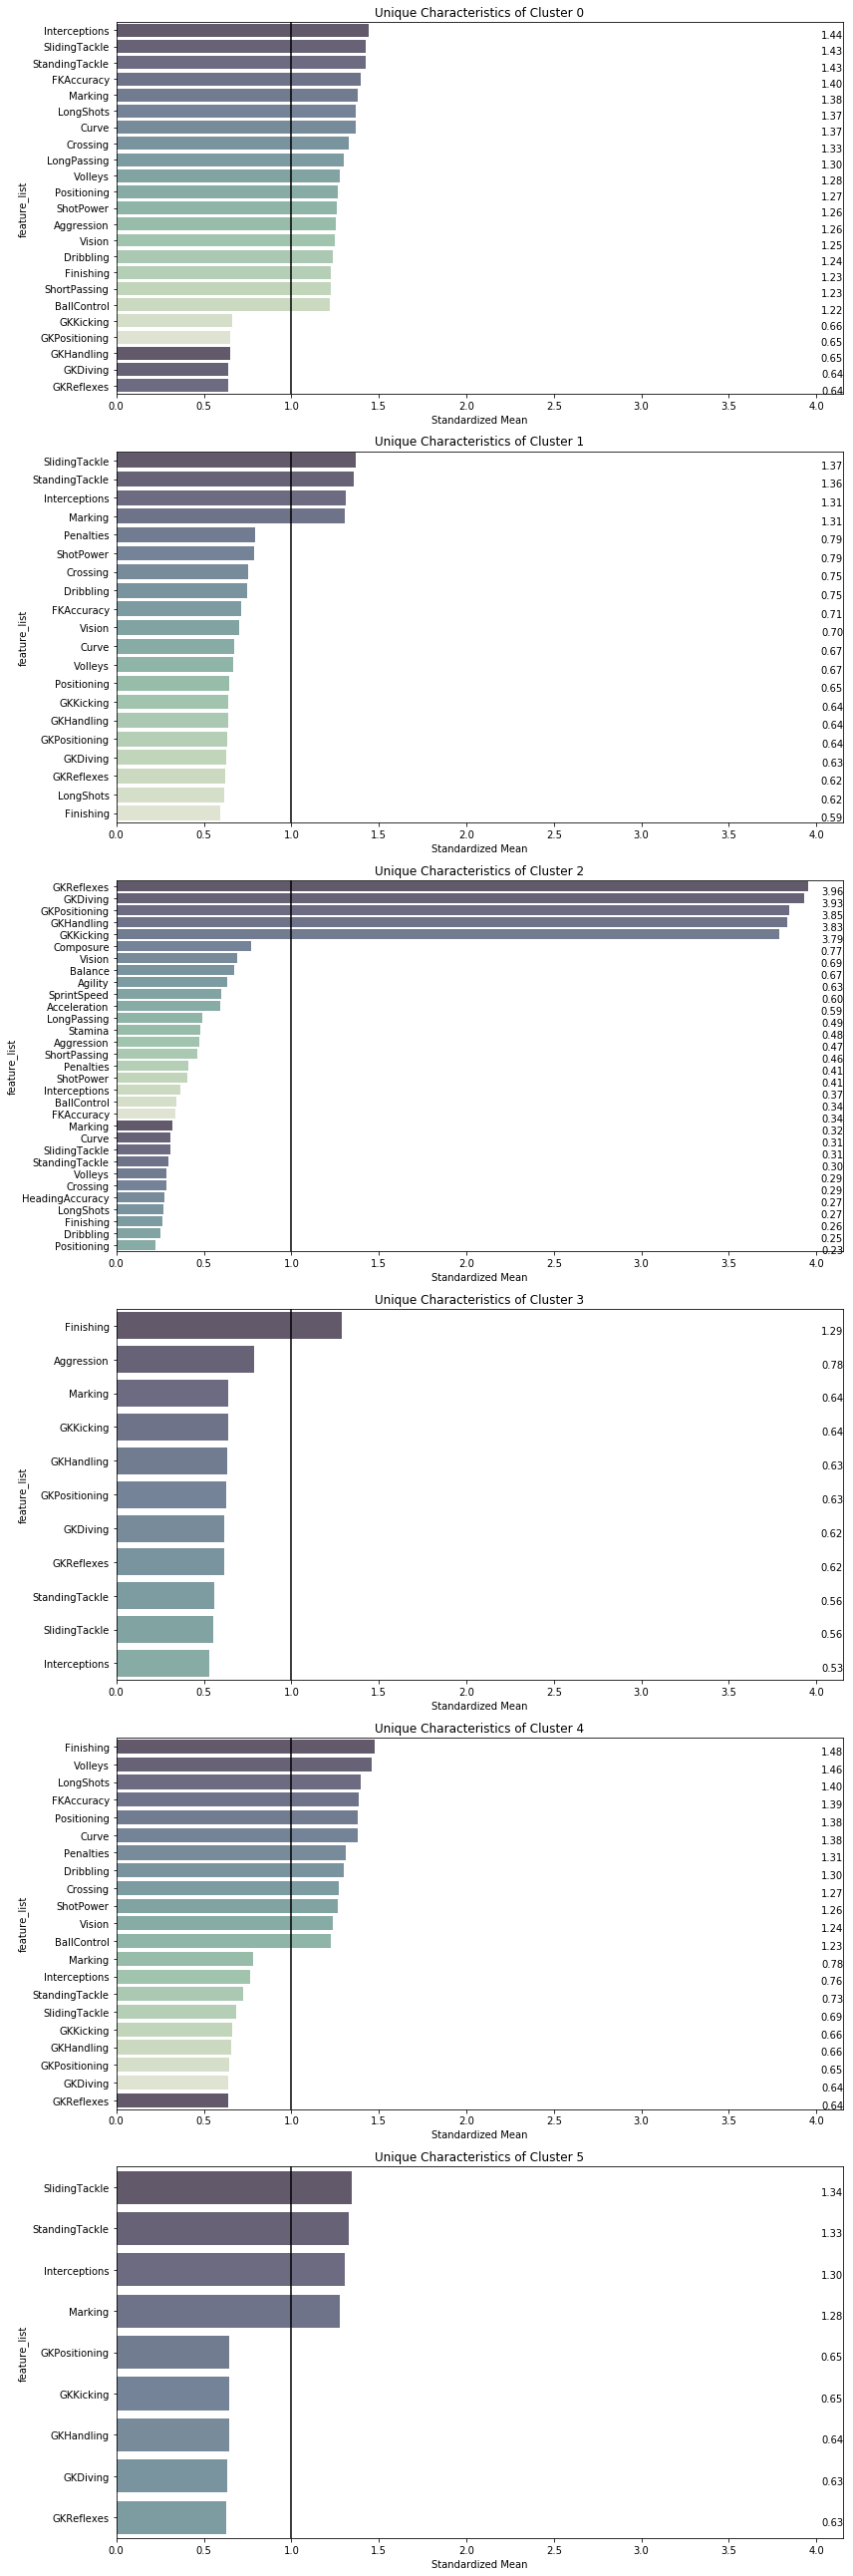

In [ ]:
plot_features_all_cluster(df=dfskills, label_col='cluster', n_clusters=6, sensitivity=0.2)